In [1]:
# Boolean aliases ----
T = True
F = False
#Import libraries ----
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set_theme()
from pathlib import Path
# Personal libraries ----
from networks.structure import STR
from modules.tribrain import triPred
from various.network_tools import *
from various.nearest_neighbors import neighbor_areas

# Declare global variables ----
linkage = "single"
nlog10 = F
lookup = F
prob = F
cut = F
subject = "MAC"
structure = "FLN"
mode = "ZERO"
distance = "tracto16"
nature = "original"
imputation_method = ""
topology = "MIX"
discovery = "discovery_7"
mapping = "trivial"
index  = "Hellinger2"
bias = 0.
alpha = 0.
version = "57"+"d"+"106"
__nodes__ = 57
__inj__ = 57

In [2]:
NET = STR[f"{subject}{__inj__}"](
    linkage, mode,
    nlog10 = nlog10,
    structure = structure,
    lookup = lookup,
    version = version,
    nature = nature,
    model = imputation_method,
    distance = distance,
    inj = __inj__,
    discovery = discovery,
    topology = topology,
    index = index,
    mapping = mapping,
    cut = cut,
    b = bias,
    alpha = alpha
)

nearest_neighbors = neighbor_areas[f"{subject}{NET.rows}"]
model = triPred(
    NET.D, NET.CC, nearest_neighbors, NET.struct_labels,
    NET.struct_labels[:NET.nodes], dist_bins=25
)

model.setup_engine()

>>> Computing the connection probabilities for known targets.
>>> Predicting all target distributions by triangulation.
>>> Setup complete.


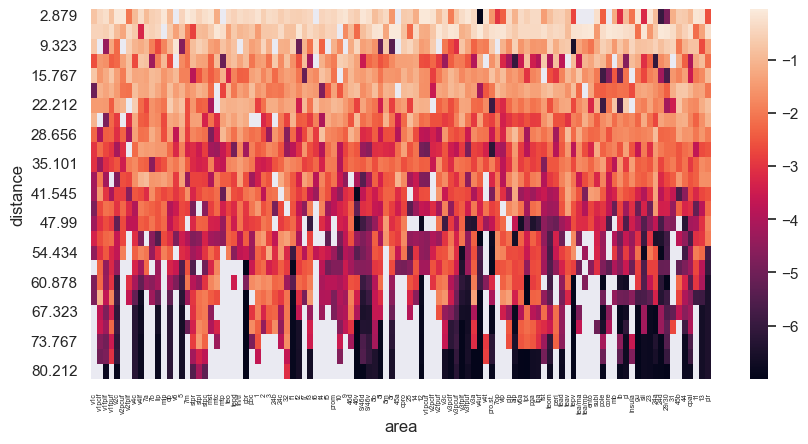

In [3]:
target_distributions = pd.DataFrame()
for i in model.total_nodes_index_range:
  target_distributions = pd.concat(
    [
      target_distributions,
      pd.DataFrame(
        {
          "area" : [NET.struct_labels[i]] * model.dist_bins,
          "P" : model.target_distance_distributions[i],
          "distance" : np.round(model.distance_bin_centers, 3)
        }
      )
    ], ignore_index=True
  )

target_distributions["P"].loc[target_distributions["P"] == 0] = np.nan
target_distributions["P"] = np.log10(target_distributions["P"])

sns.heatmap(
  data=target_distributions.pivot(index="distance", columns="area", values="P"),
  xticklabels=NET.struct_labels
)

plt.gca().set_xticklabels(plt.gca().get_xticklabels(), fontsize=5)
plt.gcf().set_figwidth(10)

In [4]:
random_count_matrix = model.generate_count_matrix(target_density=0.59)
random_fln_matrix = random_count_matrix.copy() / np.sum(random_count_matrix, axis=0)
random_fln_known_graph = random_fln_matrix[:, :NET.nodes]

>>> Generate count random matrix.
>>> Done.


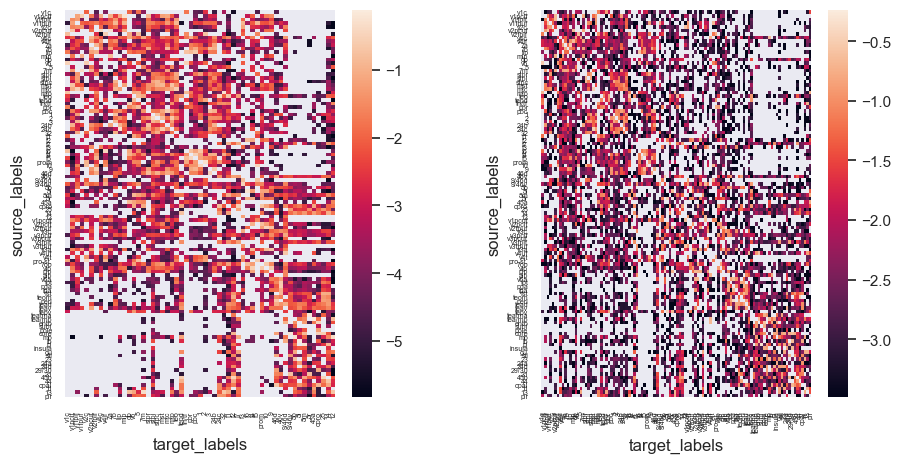

In [5]:
fig, ax = plt.subplots(1, 2)

experimental_fln_df = adj2df(NET.A)
experimental_fln_df["weight"].loc[experimental_fln_df["weight"] == 0] = np.nan
experimental_fln_df["weight"] = np.log10(experimental_fln_df["weight"])
experimental_fln_df["source_labels"] = NET.struct_labels[experimental_fln_df["source"]]
experimental_fln_df["target_labels"] = NET.struct_labels[experimental_fln_df["target"]]

random_fln_df = adj2df(random_fln_matrix)
random_fln_df["weight"].loc[random_fln_df["weight"] == 0] = np.nan
random_fln_df["weight"] = np.log10(random_fln_df["weight"])
random_fln_df["source_labels"] = NET.struct_labels[random_fln_df["source"]]
random_fln_df["target_labels"] = NET.struct_labels[random_fln_df["target"]]

sns.heatmap(
  data = experimental_fln_df.pivot(index="source_labels", columns="target_labels", values="weight"),
  xticklabels=NET.struct_labels[:NET.nodes],
  yticklabels=NET.struct_labels,
  ax=ax[0]
)

sns.heatmap(
  data = random_fln_df.pivot(index="source_labels", columns="target_labels", values="weight"),
  xticklabels=NET.struct_labels,
  yticklabels=NET.struct_labels,
  ax=ax[1]
)

for ax_index in ax:
  ax_index.set_xticklabels(ax_index.get_xticklabels(), fontsize=5)
  ax_index.set_yticklabels(ax_index.get_yticklabels(), fontsize=5)

fig.tight_layout()
fig.set_figwidth(10)


<AxesSubplot:xlabel='distance', ylabel='weight'>

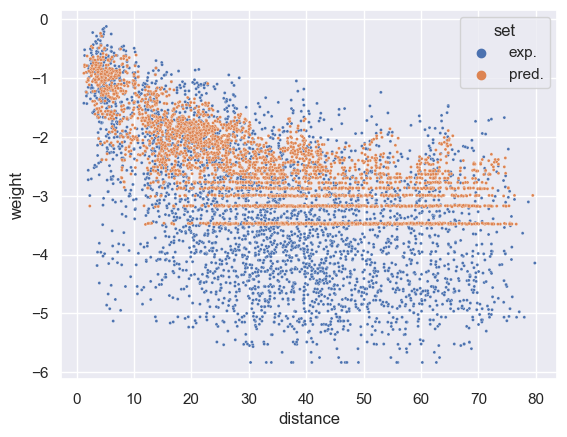

In [6]:
# Comparing predictions and experimental values (distances)

know_distance_df = adj2df(NET.D[:, :NET.nodes])
know_random_fln_df = random_fln_df.copy()
know_random_fln_df = know_random_fln_df.loc[know_random_fln_df["target"] < NET.nodes]

nb_rows = know_distance_df.shape[0]

values_data = pd.DataFrame(
  {
    "weight" : list(experimental_fln_df["weight"]) + list(know_random_fln_df["weight"]),
    "distance" : list(know_distance_df["weight"]) * 2,
    "set" : ["exp."] * nb_rows + ["pred."] * nb_rows
  }
)

sns.scatterplot(
  data=values_data,
  x="distance",
  y="weight",
  hue="set",
  s=5
)

(-0.027877169162164005, 0.36095135144518087)


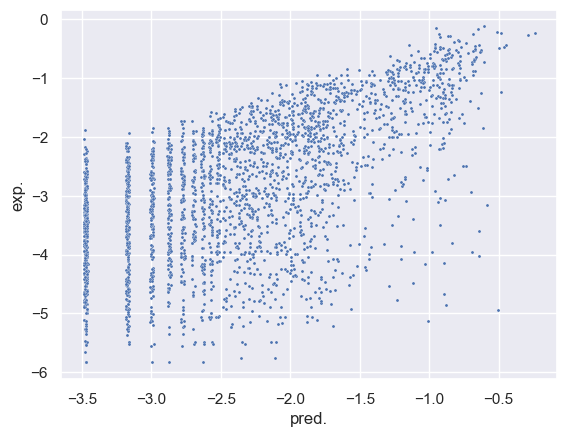

In [7]:
# Comparing predictions and experimental values (one-to-one)

values_data = pd.DataFrame(
  {
    "exp." : list(experimental_fln_df["weight"]),
    "pred." :  list(know_random_fln_df["weight"])
  }
)

sns.scatterplot(
  data=values_data,
  x="pred.",
  y="exp.",
  s=5
)

no_nan = (~np.isnan(experimental_fln_df["weight"])) & (~np.isnan(know_random_fln_df["weight"]))
from scipy.stats import pearsonr
corr = pearsonr(experimental_fln_df["weight"].loc[no_nan], know_random_fln_df["weight"].loc[no_nan])

print(corr)

In [8]:
rmae = [np.abs(expw - rw) / np.abs(expw) for expw, rw in zip(experimental_fln_df["weight"].loc[no_nan], know_random_fln_df["weight"].loc[no_nan])]
rmae = np.array(rmae)
global_rmae = np.mean(rmae)
print(f"RMAE {global_rmae:.3f}")

RMAE 0.540


<AxesSubplot:xlabel='distance', ylabel='D12'>

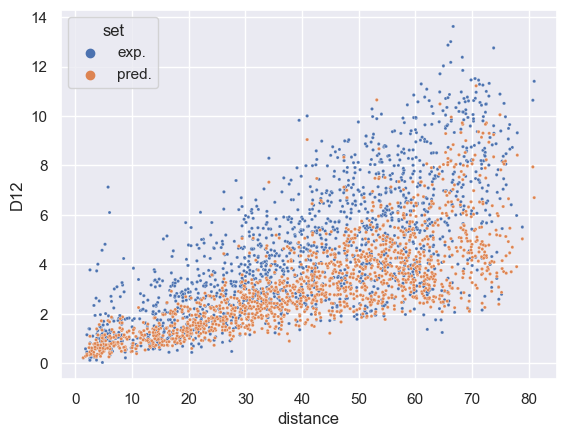

In [9]:
import ctools as ct

know_nodes_range = np.arange(NET.nodes)
target_sim_matrix_exp = np.zeros((NET.nodes, NET.nodes)) * np.nan
target_sim_matrix_pred = np.zeros((NET.nodes, NET.nodes)) * np.nan
for i in know_nodes_range:
  for j in np.arange(i+1, NET.nodes):
    target_sim_matrix_exp[i,j] = ct.Hellinger2(NET.A[:, i], NET.A[:, j], i, j)
    target_sim_matrix_pred[i,j] = ct.Hellinger2(random_fln_matrix[:, i], random_fln_matrix[:, j], i, j)
    
    target_sim_matrix_exp[j,i] = target_sim_matrix_exp[i,j]
    target_sim_matrix_pred[j,i] = target_sim_matrix_pred[i,j]

distances_known_graph = NET.D[:NET.nodes, :NET.nodes]
target_d12_matrix_exp = -2 * np.log(target_sim_matrix_exp.ravel())
target_d12_matrix_pred = -2 * np.log(target_sim_matrix_pred.ravel())

nb_rows = target_d12_matrix_exp.shape[0]

values_data = pd.DataFrame(
  {
    "D12" : list(target_d12_matrix_exp) + list(target_d12_matrix_pred),
    "distance" : list(distances_known_graph.ravel()) * 2,
    "set" : ["exp."] * nb_rows + ["pred."] * nb_rows
  }
)

sns.scatterplot(
  data=values_data.loc[values_data["D12"] < 20],
  x="distance",
  y="D12",
  hue="set",
  s=5
)

In [10]:
from modules.hierarmerge import Hierarchy
from networks.toy import TOY
from modules.colregion import colregion

RANDOM_NET = TOY(
  random_fln_known_graph, linkage, index=index
)
RANDOM_NET.set_labels(NET.struct_labels)

H = Hierarchy(
  RANDOM_NET, RANDOM_NET.A, RANDOM_NET.A, NET.D,
  __nodes__, linkage, mode, lookup=lookup, index=index
)

H.BH_features_cpp_no_mu()
H.link_entropy_cpp("short", cut=cut)
H.la_abre_a_merde_cpp(H.BH[0])
H.node_entropy_cpp("short", cut=cut)
H.entropy = [
  H.node_entropy, H.node_entropy_H,
  H.link_entropy, H.link_entropy_H
]
L = colregion(NET, labels_name=f"labels{__inj__}")
H.set_colregion(L)

Compute link hierarchical agglomeration ----
Mu-free
Starting Z2dict

	link entropy :  Sh : 0.4868, and Sv : 0.5132


	link entropy H: Sh : 0.4680, and Sv : 0.5320

Compute node hierarchy ----
Level information
Vertex entropy
Vertex entropy H
Level entropy
Level entropy H
Number of vertices in the tree: 3767
Commencer: la abre a merde
25%
50%
75%
Voila, bon ami

	Node entropy :  Sh : 0.2471, and Sv : 0.7529


	Node entropy H: Sh : 0.2229, and Sv : 0.7771

Starting Z2dict
Level information
Vertex entropy
Vertex entropy H
Level entropy
Level entropy H
Number of vertices in the tree: 113


../pickle/MAC/57d106/FLN/original/tracto16/57/SINGLE_106_57/ZERO/MIX_Hellinger2_trivial/b_0.0/discovery_7/hanalysis.pk
Visualize node-community dendrogram!!!
Visualize logFLN heatmap!!!


/Users/jmarti53/Documents/Projects/LINKPROJECT/Dlink/plotting_jupyter/plotting_H.py:538: RuntimeWarning: divide by zero encountered in log
  W = func(W)


Visualize k LCs!!!
*** both
Omega: 0.6517


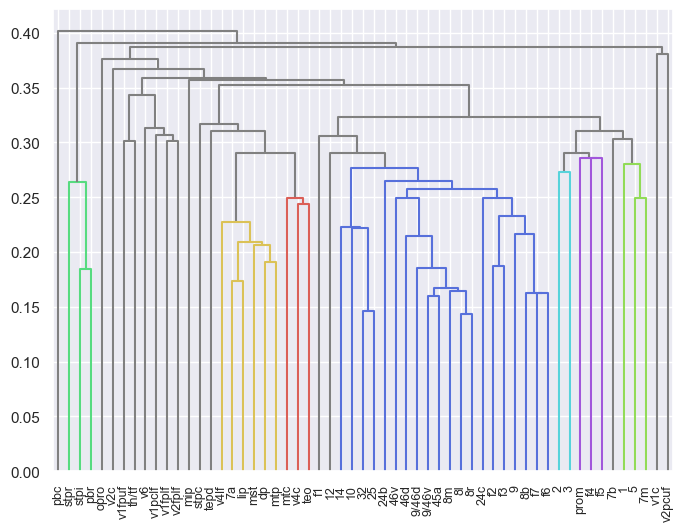

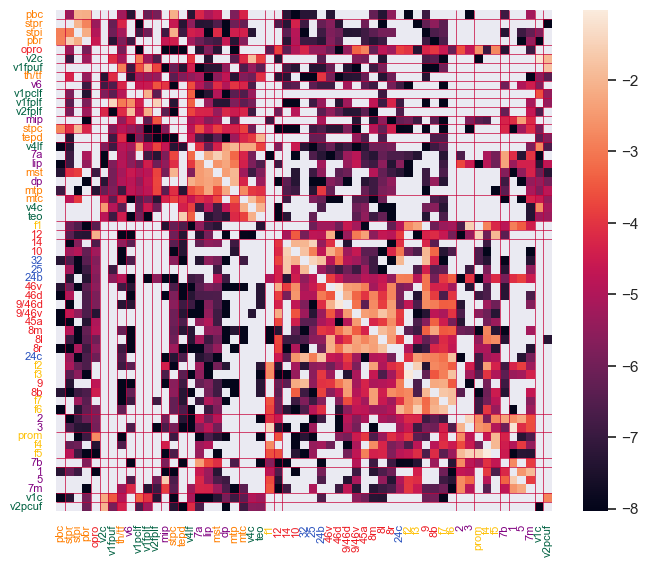

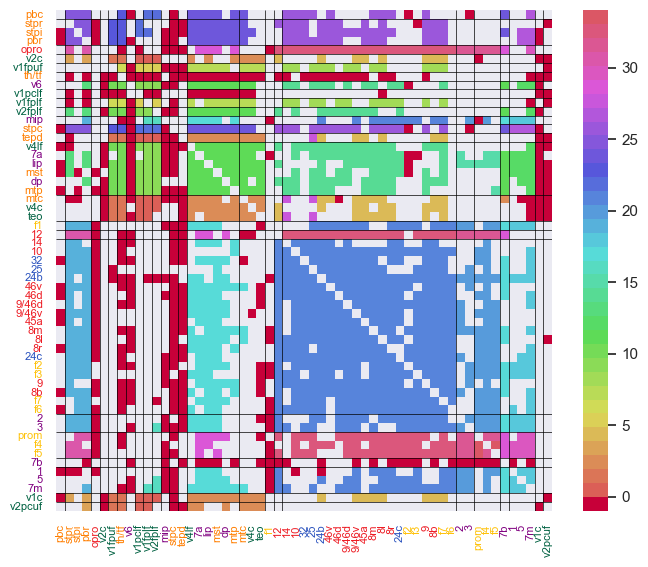

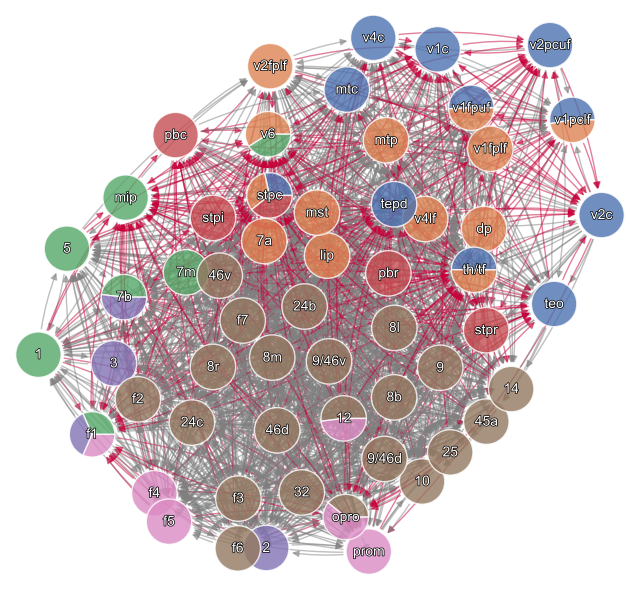

In [11]:
from modules.discovery import discovery_7
from plotting_jupyter.plotting_H import Plot_H
from matplotlib.colors import to_hex

plot_h = Plot_H(RANDOM_NET, H)
NET_H = read_class(NET.pickle_path, "hanalysis")

conductance_matrix = RANDOM_NET.A[:NET.nodes, :NET.nodes].copy()
conductance_matrix[conductance_matrix == 0] = np.nan
conductance_matrix = - np.log(conductance_matrix)
conductance_matrix[np.isnan(conductance_matrix)] = 0


for SCORE in ["_S"]:
    # Get k from RANDOM_NET ----
    K, R, _ = get_best_kr_equivalence(SCORE, H)
    for k, r in zip(K, R):
      H.set_kr(k, r, SCORE)
      rlabels = get_labels_from_Z(H.Z, r)
      rlabels = skim_partition(rlabels)
      # Plot H ----
      plot_h.core_dendrogram([r], fontsize=9, figheight=6, figwidth=8)
      plot_h.heatmap_dendro(r, fontsize=8, figheight=6.5, figwidth=8, linewidth=0.5, func=np.log)
      plot_h.lcmap_dendro(k, r, font_size=8, figheight=6.5, linewidth=0.5, figwidth=8) 
      # Overlap ----
      for direction in ["both"]:
        print("***", direction)
        _, covers, noc_sizes, rlabels2 = discovery_7(
          H, k, rlabels, direction=direction, index=index
        )
        cover = omega_index_format(rlabels2, covers, H.colregion.labels[:H.nodes])
        omega_index(cover, NET_H.cover[direction][SCORE])
        plot_h.plot_network_combined(
          k, conductance_matrix, rlabels2,
          covers, noc_sizes, cmap_name="deep", font_size=10
        )